1) scikit-optimize (https://scikit-optimize.github.io/stable/)

In [1]:
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


In [2]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

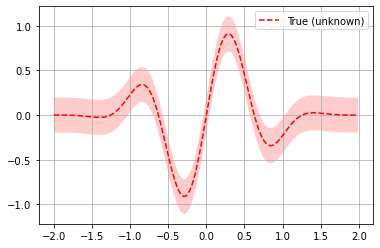

In [3]:
# Plot f(x) + contours

bounds = np.array([[-2.0, 2.0]])

x = np.linspace(bounds[:, 0], bounds[:, 1], 400).reshape(-1, 1)
x = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [4]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed


In [5]:
# res = gp_minimize(lambda x: f(np.array(x)), 
#                   bounds.tolist(),
#                   acq_func="EI",      # the acquisition function
#                   xi=0.01,            # exploitation-exploration trade-off
#                   n_calls=50,         # the number of evaluations of f
#                   n_random_starts=50,  # the number of random initialization points
#                   noise=0.1**2,       # the noise level (optional)
#                   random_state=1234)   # the random seed

In [6]:
res

          fun: -1.0079192525260336
    func_vals: array([ 0.03716044,  0.00673852,  0.63515442, -0.16042062,  0.10695907,
       -0.24436726, -0.58630532,  0.05238726, -1.00791925, -0.98466748,
       -0.86259916,  0.18102445, -0.10782771,  0.00815673, -0.79756401])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True

In [7]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.3552, f(x^*)=-1.0079'

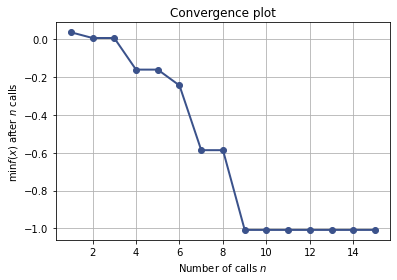

In [8]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [9]:
def f_wo_noise(x):
    return f(x, noise_level=0)

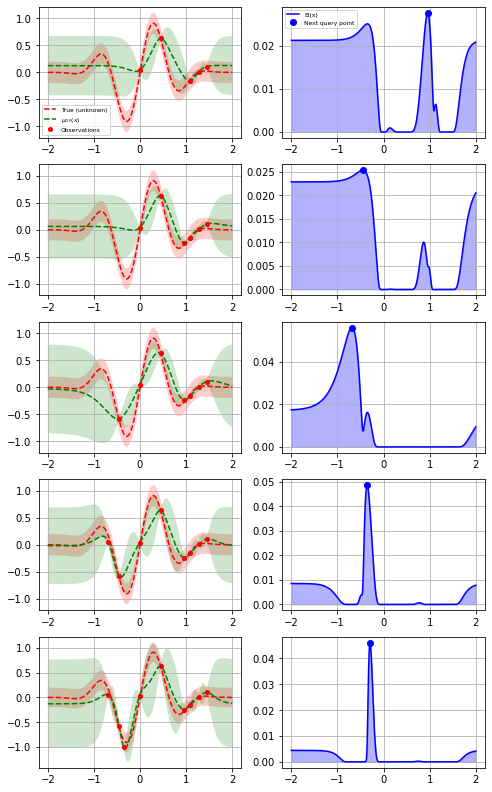

In [10]:
plt.rcParams["figure.figsize"] = (8, 14)

for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

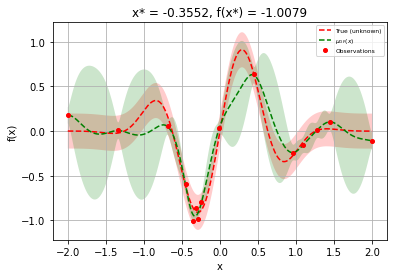

In [11]:
plt.rcParams["figure.figsize"] = (6, 4)
# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=noise_level)

plt.show()

In [12]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.8) 
    plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
    plt.plot(X, mu, 'b--', lw=2, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

In [13]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern


res = gp_minimize(lambda x: f(np.array(x)), 
                bounds.tolist(),
                  acq_func="EI",      # the acquisition function
                  xi=0.01,            # exploitation-exploration trade-off
                  n_calls=20,         # the number of evaluations of f
                  n_random_starts=20,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [14]:
res

          fun: -0.717872794245223
    func_vals: array([ 0.04989585, -0.06771194,  0.594152  ,  0.02438112,  0.03670581,
       -0.16301397,  0.12856472,  0.14738279, -0.07577965,  0.03690644,
       -0.34452139, -0.2903819 ,  0.15985837, -0.00494498, -0.02286615,
        0.0180796 , -0.71787279, -0.05514597,  0.28407962,  0.2624841 ])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775)]
 random_state: RandomState(MT19937) at 0x7FBC4743E468
        space: Space([Real(low=-2.0, high=2.0, prior='uniform', transform='normalize')])
        specs: {'args': {'model_queue_size': None, 'n_jobs': 1, 'kappa': 1.96, 'xi': 0.01, 'n_restarts_optimizer': 5, 'n_points': 10000, 'callback': None, 'verbose': False, 'random_state': RandomState(MT19937) at 0x7FBC4743E468, 'y0': None, 'x0': None, 'a

In [15]:
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
#X = np.linspace(-2, 2, 400).reshape(-1, 1)

def f(X, noise_level=noise_level):
    return np.sin(5 * X) * (1 - np.tanh(X ** 2))+ noise_level * np.random.randn(*X.shape)

# Noise-free objective function values at X 
Y = f(X)
X.shape, Y.shape

((400, 1), (400, 1))

In [16]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern


res = gp_minimize(lambda x: f(np.array(x))[0], 
                bounds.tolist(),
                  acq_func="EI",      # the acquisition function
                  xi=0.01,            # exploitation-exploration trade-off
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=20,  # the number of random initialization points
                  noise=0.0**2,       # the noise level (optional)
                  random_state=1234)   # the random seed


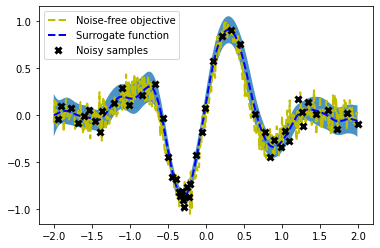

In [17]:
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise_level**2)

# Fit GP model to samples for plotting results
gpr.fit(res.x_iters, res.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, res.x_iters, res.func_vals, show_legend=True)

2) GPy (https://github.com/SheffieldML/GPy)

In [18]:
import GPy
import GPyOpt
from functools import partial

from GPyOpt.methods import BayesianOptimization

In [19]:
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 noise_var = 0,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)

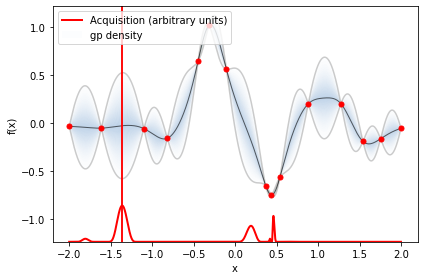

In [20]:
plt.rcParams["figure.figsize"] = (6, 4)

optimizer.plot_acquisition()

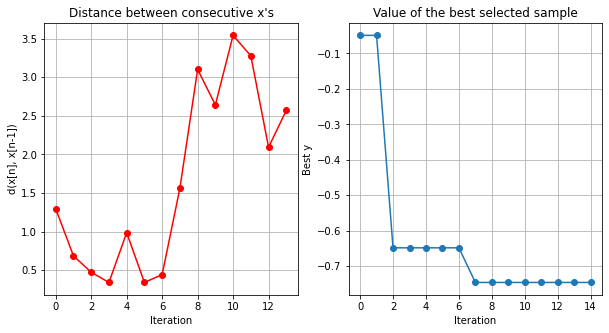

In [21]:
optimizer.plot_convergence()

3) BayesianOptimization #https://github.com/fmfn/BayesianOptimization

In [22]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 2))
    acq.set_ylim((-1, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [23]:
def black_box_function(x):

    return -1*(np.sin(5 * x) * (1 - np.tanh(x ** 2)))

In [24]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x': (-2, 2)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,)

In [25]:
optimizer.maximize(
    init_points=10,
    n_iter=10)

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8868    | -0.3319   |
| 2         | 0.333     | 0.8813    |
| 3         | -0.000364 | -2.0      |
| 4         | -0.3231   | -0.7907   |
| 5         | 0.02552   | -1.413    |
| 6         | 0.009324  | -1.631    |
| 7         | -0.000689 | -1.255    |
| 8         | 0.03356   | -0.6178   |
| 9         | 0.7318    | -0.4129   |
| 10        | -0.6838   | 0.1553    |
| 11        | -0.01646  | 1.31      |
| 12        | 0.0003649 | 2.0       |
| 13        | 0.8258    | -0.2083   |
| 14        | 0.333     | 0.8813    |
| 15        | 0.9062    | -0.2732   |
| 16        | 0.9089    | -0.2954   |
| 17        | 0.9094    | -0.2887   |
| 18        | 0.9094    | -0.289    |
| 19        | 0.9094    | -0.2892   |
| 20        | 0.9094    | -0.2892   |


In [26]:
print(optimizer.max)

{'target': 0.9094297946146589, 'params': {'x': -0.28924573069453235}}


In [27]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.8867730209588112, 'params': {'x': -0.331911981189704}}
Iteration 1: 
	{'target': 0.33298845362326, 'params': {'x': 0.8812979737686324}}
Iteration 2: 
	{'target': -0.00036491938593243413, 'params': {'x': -1.9995425007306205}}
Iteration 3: 
	{'target': -0.3230567907845687, 'params': {'x': -0.7906697094726409}}
Iteration 4: 
	{'target': 0.02551669259558465, 'params': {'x': -1.4129764367315478}}
Iteration 5: 
	{'target': 0.009323543720517585, 'params': {'x': -1.6306456209248088}}
Iteration 6: 
	{'target': -0.0006895678336868447, 'params': {'x': -1.2549591544893164}}
Iteration 7: 
	{'target': 0.033563601583546446, 'params': {'x': -0.617757091827809}}
Iteration 8: 
	{'target': 0.7318134467478039, 'params': {'x': -0.41293010307732025}}
Iteration 9: 
	{'target': -0.6837806444517969, 'params': {'x': 0.15526693601342778}}
Iteration 10: 
	{'target': -0.016463384013683423, 'params': {'x': 1.3097989286671141}}
Iteration 11: 
	{'target': 0.00036487510102654235, 'params': 

In [28]:
x_ = np.linspace(-2, 2, 1000).reshape(-1, 1)
y_= black_box_function(x_)
x_.shape, y_.shape

((1000, 1), (1000, 1))

|   iter    |  target   |     x     |
-------------------------------------
| 21        | 0.895     | -0.3232   |
| 22        | 0.2669    | 0.7409    |
| 23        | -0.04189  | -1.182    |
| 24        | -0.01954  | 1.512     |
| 25        | -4.318e-0 | -1.89     |
| 26        | 0.1497    | 0.6819    |
| 27        | 0.8879    | -0.3308   |
| 28        | -0.8715   | 0.2348    |
| 29        | 0.02477   | -1.438    |
| 30        | -0.02493  | -1.208    |
| 31        | 0.9094    | -0.2895   |
| 32        | 0.9094    | -0.2895   |
| 33        | 0.9094    | -0.2896   |
| 34        | 0.9094    | -0.2894   |
| 35        | 0.9094    | -0.2894   |
| 36        | 0.9094    | -0.2894   |
| 37        | 0.9094    | -0.2894   |
| 38        | 0.9094    | -0.2893   |
| 39        | 0.9094    | -0.2893   |
| 40        | 0.9094    | -0.2893   |


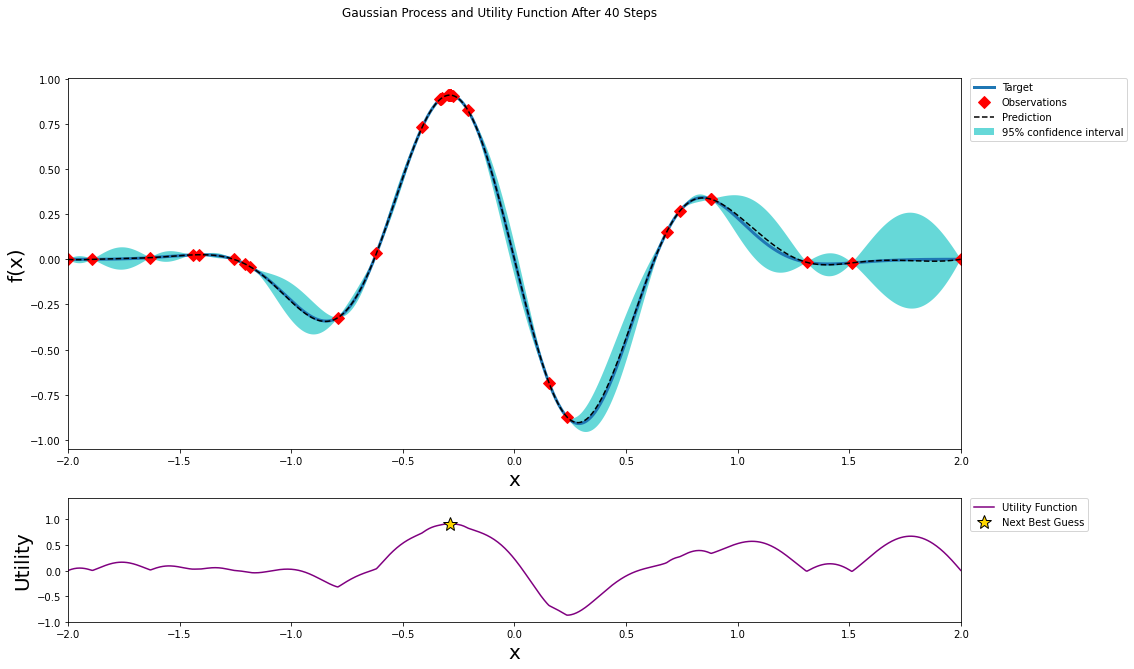

In [29]:
optimizer.maximize(init_points=10, n_iter=10, kappa=5)
plot_gp(optimizer, x_, y_)

|   iter    |  target   |     x     |
-------------------------------------
| 41        | 0.0278    | 1.203     |
| 42        | -0.000106 | 1.873     |
| 43        | -0.275    | -0.7463   |
| 44        | 0.3038    | 0.7693    |
| 45        | -0.02014  | 1.506     |
| 46        | -0.01361  | 1.578     |
| 47        | 0.007274  | -1.66     |
| 48        | 0.0004553 | -1.844    |
| 49        | 0.01866   | -1.321    |
| 50        | -0.01953  | 1.513     |
| 51        | 0.9094    | -0.2893   |
| 52        | 0.9094    | -0.2893   |
| 53        | 0.9094    | -0.2894   |
| 54        | 0.9094    | -0.2893   |
| 55        | 0.9094    | -0.2893   |
| 56        | 0.9094    | -0.2893   |
| 57        | 0.9094    | -0.2893   |
| 58        | 0.9094    | -0.2893   |
| 59        | 0.9094    | -0.2893   |
| 60        | 0.9094    | -0.2893   |


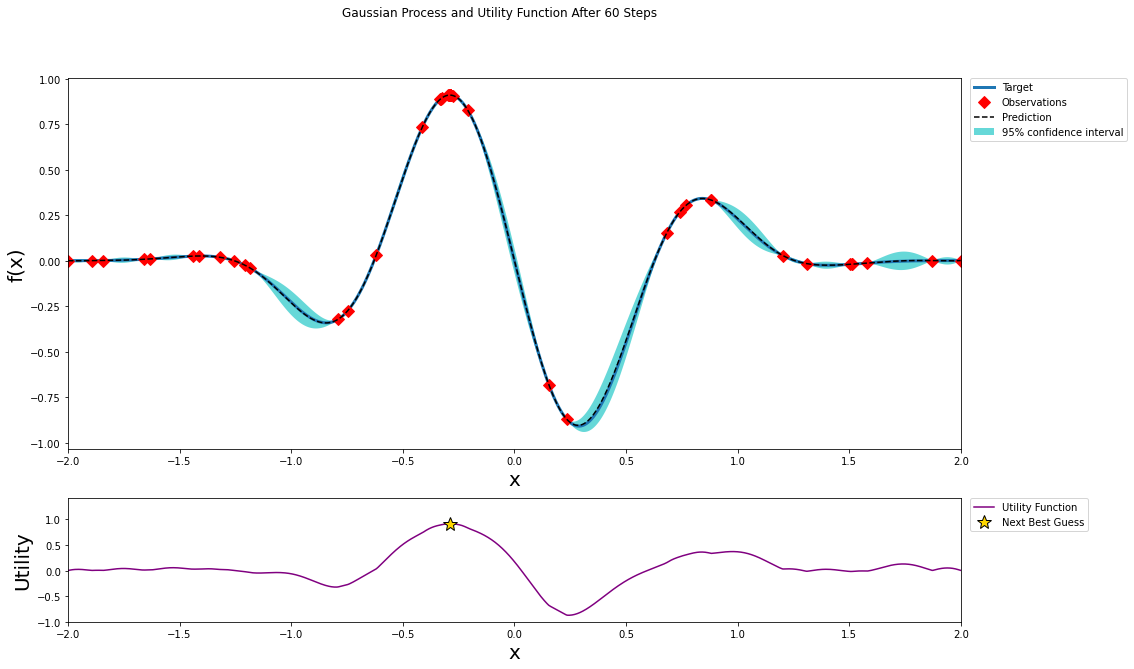

In [30]:
optimizer.maximize(init_points=10, n_iter=10, kappa=0.1)
plot_gp(optimizer, x_, y_)

|   iter    |  target   |     x     |
-------------------------------------
| 61        | 0.01121   | -1.607    |
| 62        | 0.9007    | -0.3156   |
| 63        | -0.000642 | 1.832     |
| 64        | -0.6049   | 0.1327    |
| 65        | 0.3018    | 0.7675    |
| 66        | -0.2624   | -0.7379   |
| 67        | 0.2745    | 0.746     |
| 68        | -0.02152  | 1.339     |
| 69        | -0.000247 | -1.927    |
| 70        | 0.228     | 1.001     |
| 71        | 0.9094    | -0.2891   |
| 72        | 0.9094    | -0.2891   |
| 73        | 0.9094    | -0.2891   |
| 74        | 0.9094    | -0.2891   |
| 75        | 0.9094    | -0.2891   |
| 76        | 0.9094    | -0.2891   |
| 77        | 0.9094    | -0.2891   |
| 78        | 0.9094    | -0.2892   |
| 79        | 0.9094    | -0.2892   |
| 80        | 0.9094    | -0.2892   |


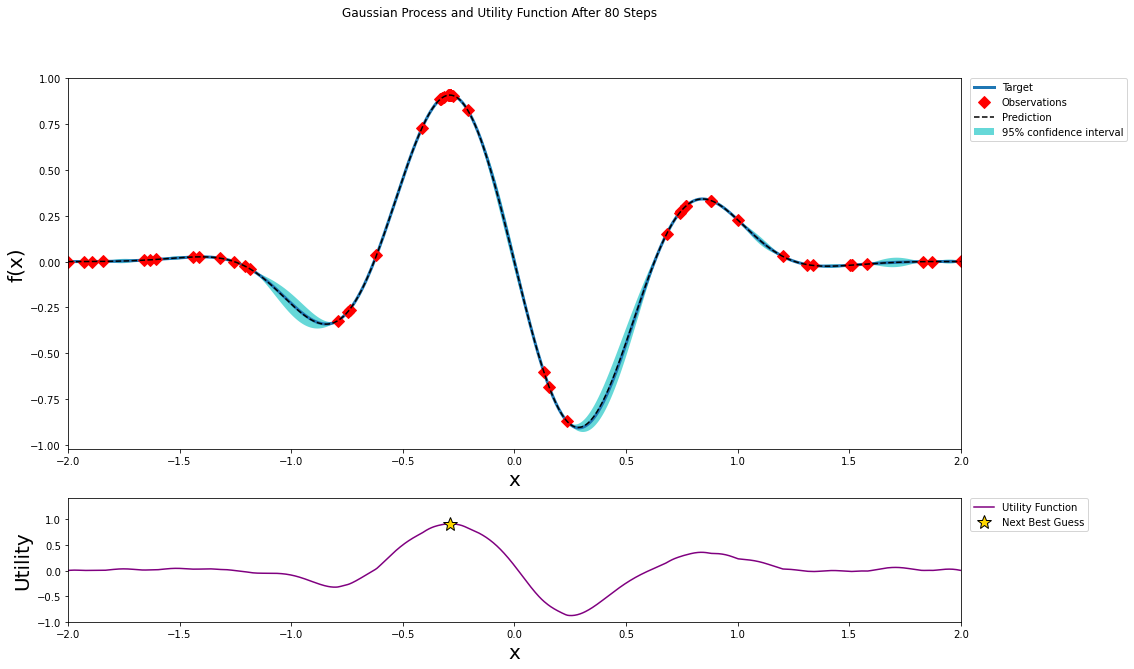

In [31]:
optimizer.maximize(init_points=10, n_iter=10, kappa=10)
plot_gp(optimizer, x_, y_)

|   iter    |  target   |     x     |
-------------------------------------
| 81        | 0.0003293 | 1.955     |
| 82        | 0.237     | 0.9927    |
| 83        | -0.3343   | -0.8782   |
| 84        | 0.06138   | 1.157     |
| 85        | 0.01285   | -1.587    |
| 86        | 0.826     | -0.2084   |
| 87        | -0.009046 | 1.634     |
| 88        | -0.3398   | -0.8255   |
| 89        | -0.3416   | -0.8489   |
| 90        | 0.02223   | -1.48     |
| 91        | 0.9094    | -0.2891   |
| 92        | 0.9094    | -0.2892   |
| 93        | 0.9094    | -0.2892   |
| 94        | 0.9094    | -0.2892   |
| 95        | 0.9094    | -0.2892   |
| 96        | 0.9094    | -0.2892   |
| 97        | 0.9094    | -0.2892   |
| 98        | 0.9094    | -0.2892   |
| 99        | 0.9094    | -0.2892   |
| 100       | 0.9094    | -0.2892   |


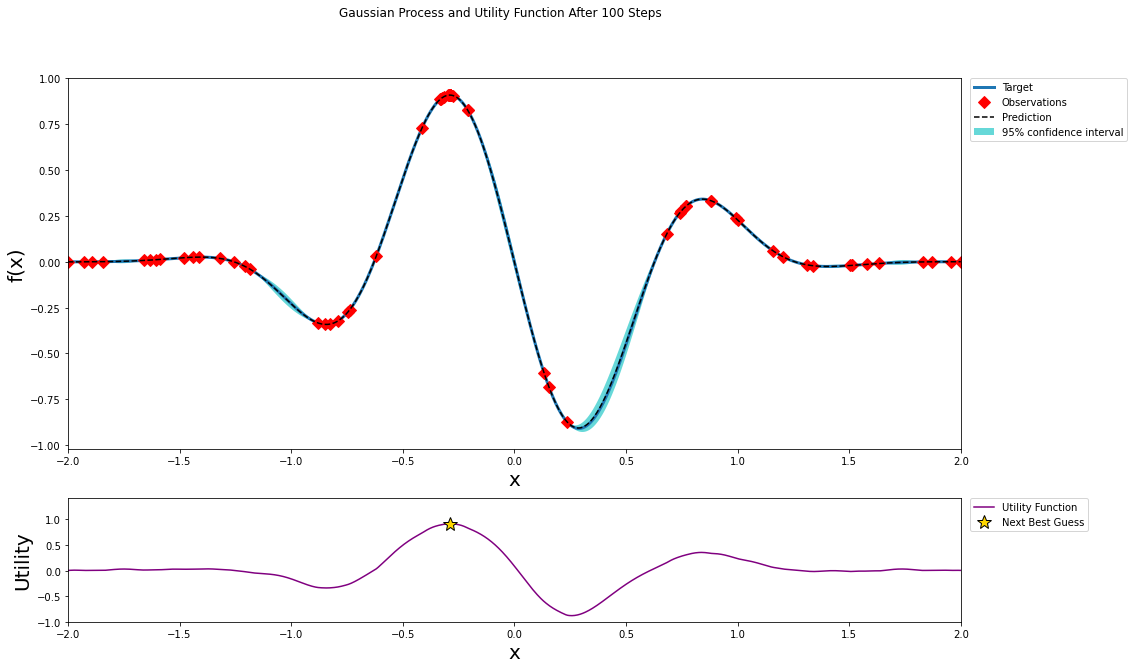

In [32]:
optimizer.maximize(init_points=10, n_iter=10,  xi=1e-4)
plot_gp(optimizer, x_, y_)

|   iter    |  target   |     x     |
-------------------------------------
| 101       | -0.00023  | -1.923    |
| 102       | 0.2229    | 0.7153    |
| 103       | -0.06442  | -1.153    |
| 104       | -0.2938   | -0.9378   |
| 105       | 0.1675    | -0.03371  |
| 106       | 0.001593  | -1.787    |
| 107       | -0.9088   | 0.2965    |
| 108       | 0.02552   | -1.413    |
| 109       | -0.8529   | 0.3572    |
| 110       | 0.3287    | 0.799     |
| 111       | 0.9094    | -0.2894   |
| 112       | 0.9094    | -0.2892   |
| 113       | 0.9094    | -0.2892   |
| 114       | 0.9094    | -0.2893   |
| 115       | 0.9094    | -0.2892   |
| 116       | 0.9094    | -0.2892   |
| 117       | 0.9094    | -0.2892   |
| 118       | 0.9094    | -0.2892   |
| 119       | 0.9094    | -0.2892   |
| 120       | 0.9094    | -0.2888   |


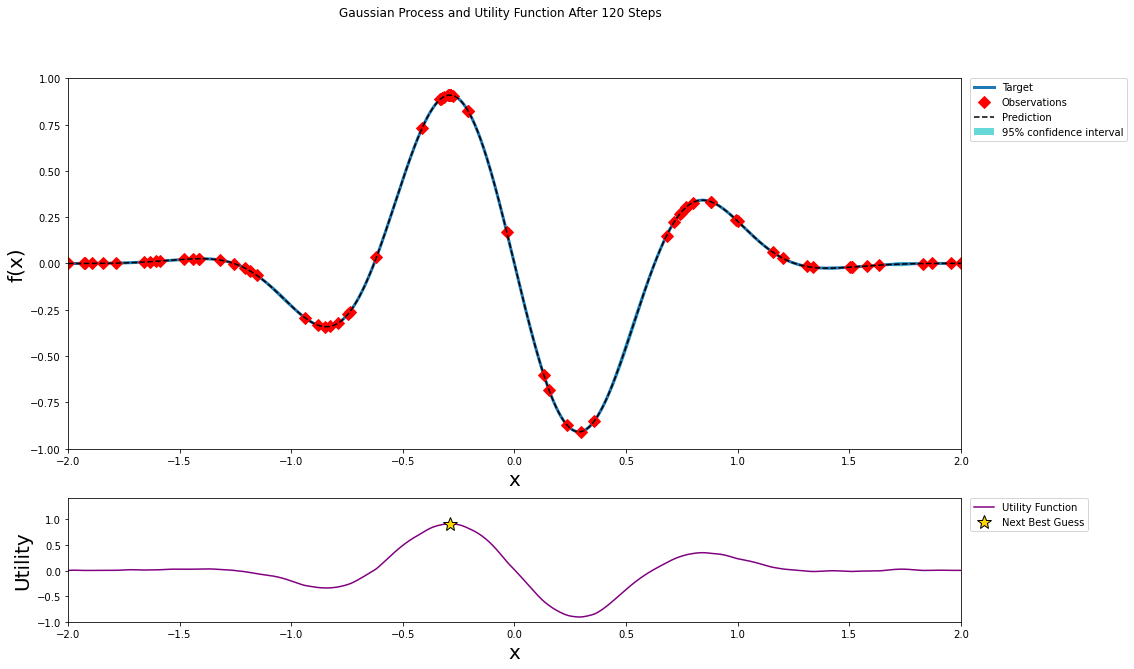

In [33]:
optimizer.maximize(init_points=10, n_iter=10,  xi=1e-1)
plot_gp(optimizer, x_, y_)

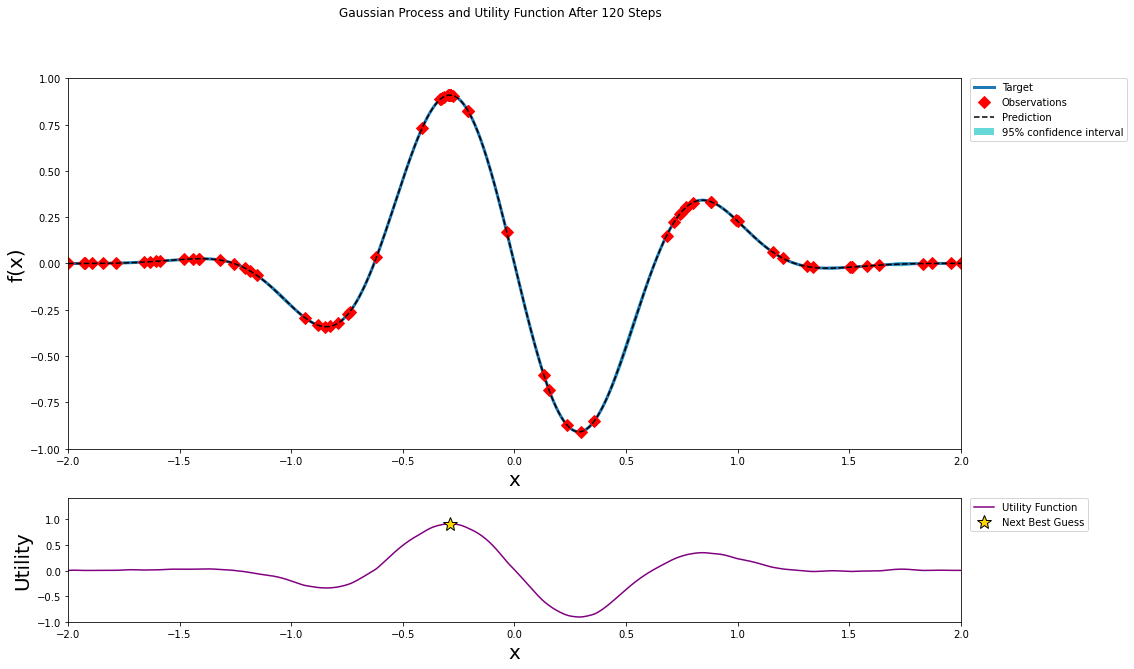

In [34]:
plot_gp(optimizer, x_, y_)